HPO


In [1]:
!pip install seaborn

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import skopt
import seaborn as sns
from neumann_gp import fitness
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

Using backend: tensorflow.compat.v1

2023-01-19 20:25:05.597888: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term

Instructions for updating:
experimental_compile is deprecated, use jit_compile instead


In [2]:
def formula(N , L):
    return N * (2+ 1) + (L-2) * N * (N + 1) + (N+1) 


def parse_results(name):
    search_result = skopt.load(name + '.pkl')
    n_calls = search_result.func_vals.shape[0]
    test = []
    metric = []
    train = []
    texec = []

    for i in range(n_calls):
        temp_name = name + '-'  + str(i) 
        train.append(skopt.load(temp_name + 'train.pkl'))
        test.append(skopt.load(temp_name + 'test.pkl'))
        metric.append(skopt.load(temp_name + 'metric.pkl'))
        texec.append(skopt.load(temp_name + 'texec.pkl'))
        


    min_train = np.zeros(n_calls)
    min_test = np.zeros(n_calls)
    min_metric = np.zeros(n_calls)

    for i in range(n_calls):
        imin = test[i].argmin()
        min_train[i] = train[i][imin]
        min_test[i] = test[i][imin]
        min_metric[i] = metric[i][imin]


    df1 = pd.DataFrame(np.column_stack([min_train, min_test, min_metric, texec]), columns = ['train', 'test', 'metric', 'texec'])    
    df0 = pd.DataFrame(search_result.x_iters,  columns=['lr', 'd', 'w', 'a', 'weight'])

    # Remove nan in metric
    max_train = df1[~np.isnan(df1.train)].max()
    max_test =  df1[~np.isnan(df1.test)].max()
    max_metric = df1[~np.isnan(df1.metric)].max()
    
    df1[np.isnan(df1.train)] = max_train
    df1[np.isnan(df1.test)] = max_test
    df1[np.isnan(df1.metric)] = max_metric
    
    df0['f'] = search_result.func_vals.astype(float)
    df0['global_index'] = np.arange(df0.shape[0]) 
    df0['information'] = '[' +df0.lr.map(lambda x : "{:.2e}".format(x)).astype(str)+ ',' + df0.d.astype(str) + ','+ df0.w.astype(str)+ ',' + df0.a.astype(str) + ',' + df0.weight.map(lambda x : "{:.2e}".format(x)).astype(str) + ']'
    df0['cost'] = formula(df0.w, df0.d + 1)
    
    
    df2 = pd.concat([df0, df1], axis = 1)
    
    conv = np.zeros(n_calls)
    conv_metric = np.zeros(n_calls)
    
    
    for i in range(n_calls):
        conv[i] = df2.f.values[:i + 1].min()
        conv_metric[i] = df2.metric.values[:i + 1].min()
    df2['conv'] = conv
    df2['conv_metric'] = conv_metric
    
    
    # Set nan values to max

    df2.loc[df2.f == 100000, 'f'] = df2.f[df2.f != 100000].max()
    #df2.loc[df2.f == 100000, 'train'] = df2.train[df2.f != 100000].max()
    #df2.loc[df2.f == 100000, 'test'] = df2.test[df2.f != 100000].max()
    
    df = df2.sort_values(['f'], ascending = [True])

    df['cost'] = df['cost'].astype(float)
    df[['global_index','f']] = df[['global_index','f']].astype(float)
    df['f'] = df['f'].astype(float)
    df['f_format'] = df.f.map(lambda x : "{:.2e}".format(x)).astype(str)
    
    df['cost_format'] = df.cost.map(lambda x : "{:.2e}".format(x)).astype(str)
    
    return df





In [3]:
name = 'results/ne0_11gp'

n_calls = 100
df = parse_results(name)
df['local_index'] = (np.arange(n_calls) + 1).astype(int)

df['log10f'] = np.log10(df.f)
df['log10metric'] = np.log10(df.metric)
df['log10train'] = np.log10(df.train)
df['log10test'] = np.log10(df.test)
df['log10conv'] = np.log10(df.conv)
df['log10conv_metric'] = np.log10(df.conv_metric)

search_result = skopt.load(name + '.pkl')

Final plot!

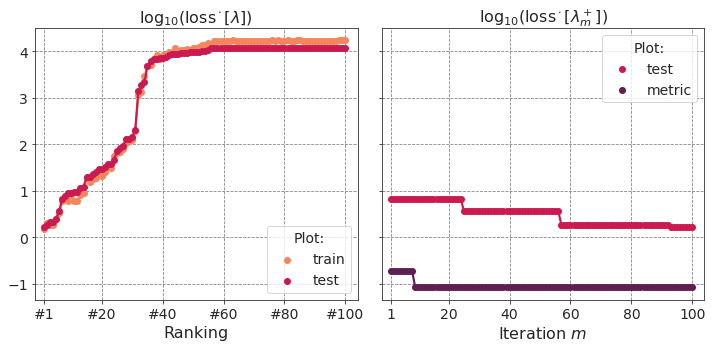

In [7]:
sns.set_style("ticks",{'axes.grid' : True})

melt = df.melt(id_vars =['local_index'], value_vars =  ['log10train', 'log10test'])
fig, (ax1, ax2) = plt.subplots(1,2 , sharey=True, figsize= (12, 5))

g = sns.pointplot(data = melt, x = 'local_index', 
                 palette = sns.color_palette('rocket_r', n_colors=3), 
                 y = 'value',
                 scale = .8,# s = 80, lw = 2,
                 hue='variable',
                 ax = ax1)
                 
#ax.set_xlabel(r'$\lambda_{M-m}^+$ Ranking')
ax1.set_title(r'$\log_{10}($loss$^\cdot[\lambda])$', fontsize=16)

ax1.set_ylabel(r'')
ax1.set_xlabel(r'Ranking', fontsize=16)


xticks = np.array([0, 19, 39, 59, 79, 99])
ax1.grid()
ax1.set_xlim(-3,103)
labels = ax1.get_xticklabels() # get x labels

ax1.set_xticks(xticks)
a = (xticks + 1).astype(str)
b = ['#' + s for s in list(a)]

ax1.set_xticklabels(b, fontsize= 14)
#ax1.set_yticklabels(labelsy, fontsize= 14)
ax1.xaxis.grid(color='gray', linestyle='dashed')
ax1.yaxis.grid(color='gray', linestyle='dashed')
#ax.tick_params(axis='both', which='major')
#title = ax.get_title()


handles, labels = ax1.get_legend_handles_labels() 

labels = ['train', 'test', 'metric']
legend = ax1.legend(loc = 'lower right', handles = handles, labels = labels, title = 'Plot:', fontsize=14)  
legend.get_title().set_fontsize('14')

# AX2
melt = df.melt(id_vars =['global_index'], value_vars =  ['log10conv','log10conv_metric'])
g = sns.pointplot(data = melt, x = 'global_index', 
                 palette = sns.color_palette('rocket_r', n_colors=3)[1:3], 
                 y = 'value',
                 scale = .8,# s = 80, lw = 2,
                 hue='variable',
                 ax = ax2)
ax2.set_xlabel(r'Iteration $m$', fontsize=16)
ax2.set_title(r'$\log_{10}($loss$^\cdot[\lambda^+_m])$', fontsize=16)
ax2.set_ylabel(r'')

xticks = np.array([0, 19, 39, 59, 79, 99])

ax2.grid()
ax2.set_xlim(-3,103)

labels = ax2.get_xticklabels() # get x labels
labelsy = ax1.get_yticklabels() # get x labels

ax1.tick_params(axis='both', which='major', labelsize=14)


ax2.set_xticks(xticks)
ax2.set_xticklabels((xticks + 1).astype(str), fontsize=14)

ax2.xaxis.grid(color='gray', linestyle='dashed')
ax2.yaxis.grid(color='gray', linestyle='dashed')
#title = ax.get_title()


handles, labels = ax2.get_legend_handles_labels() 

labels = ['test', 'metric']
legend = ax2.legend(loc = 'upper right', handles = handles, labels = labels, title = 'Plot:',fontsize =14)  
legend.get_title().set_fontsize('14')


plt.subplots_adjust(wspace=0.075, hspace=0.075)

plt.savefig('plots/s31.pdf')

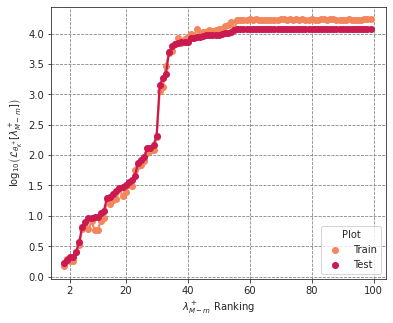

In [8]:
sns.set_style("ticks",{'axes.grid' : True})

melt = df.melt(id_vars =['local_index'], value_vars =  ['log10train', 'log10test'])
fig, ax = plt.subplots(figsize= (6,5))

g = sns.pointplot(data = melt, x = 'local_index', 
                 palette = sns.color_palette('rocket_r', n_colors=3), 
                 y = 'value',
                 scale = .8, s = 80, lw = 2,
                 hue='variable',
                 ax = ax)
                 
                 
ax.set_xlabel(r'$\lambda_{M-m}^+$ Ranking')
ax.set_ylabel(r'$\log_{10}\left(\mathcal{L}_{\theta_K^+}[\lambda_{M-m}^+]\right)$')



xticks = np.array([1, 19, 39, 59, 79, 99])+1

ax.grid()
ax.set_xlim(-4,104)

labels = ax.get_xticklabels() # get x labels

ax.set_xticks(xticks)
ax.set_xticklabels((xticks).astype(str))
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.tick_params(axis='both', which='major')
title = ax.get_title()


handles, labels = ax.get_legend_handles_labels() 

labels = ['Train', 'Test', 'Metric']
ax.legend(loc = 'lower right', handles = handles, labels = labels, title = 'Plot')  
plt.savefig('plots/s31.pdf')

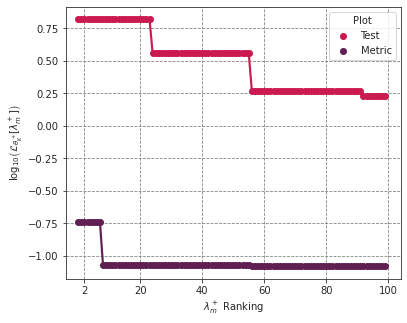

In [9]:
sns.set_style("ticks",{'axes.grid' : True})

melt = df.melt(id_vars =['global_index'], value_vars =  ['log10conv','log10conv_metric'])
fig, ax = plt.subplots(figsize= (6,5))

g = sns.pointplot(data = melt, x = 'global_index', 
                 palette = sns.color_palette('rocket_r', n_colors=3)[1:3], 
                 y = 'value',
                 scale = .8, s = 80, lw = 2,
                 hue='variable',
                 ax = ax)
                 
                 
ax.set_xlabel(r'$\lambda_{m}^+$ Ranking')
ax.set_ylabel(r'$\log_{10}\left(\mathcal{L}_{\theta_K^+}[\lambda_{m}^+]\right)$')



xticks = np.array([1, 19, 39, 59, 79, 99])+1

ax.grid()
ax.set_xlim(-4,104)

labels = ax.get_xticklabels() # get x labels

ax.set_xticks(xticks)
ax.set_xticklabels((xticks).astype(str))
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')
#ax.tick_params(axis='both', which='major')
title = ax.get_title()


handles, labels = ax.get_legend_handles_labels() 

labels = ['Test', 'Metric']
ax.legend(loc = 'upper right', handles = handles, labels = labels, title = 'Plot')  
plt.savefig('plots/s32.pdf')

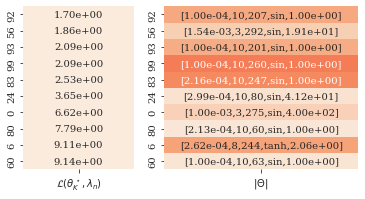

In [10]:
dftemp = df[df['local_index'] <= 10]
fmin, fmax = df.f.min(), df.f.max()
cmin, cmax = df.cost.min(), df.cost.max()

plt.rc('font', family='serif')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 3), gridspec_kw={'width_ratios': [1,1.75]})
g =  sns.heatmap(dftemp[['f']], annot =dftemp[['f_format']], fmt = '' , cmap = 'rocket_r', ax = ax1, cbar_kws = dict(use_gridspec=False,location="left"), cbar = None, xticklabels = [r'$\mathcal{L}(\theta_K^\star, \lambda_n)$'], vmin = fmin, vmax=fmax)
g =  sns.heatmap(dftemp[['cost']], annot =dftemp[['information']], fmt = '' , cmap = 'rocket_r', ax = ax2, cbar = None, xticklabels = [r'$|\Theta|$'], vmin = cmin, vmax = cmax)
ax1.xaxis.tick_bottom() # x axis on top

#ax1.xaxis.set_label_position('top')


ax2.xaxis.tick_bottom() # x axis on top

plt.savefig('plots/s34.pdf')



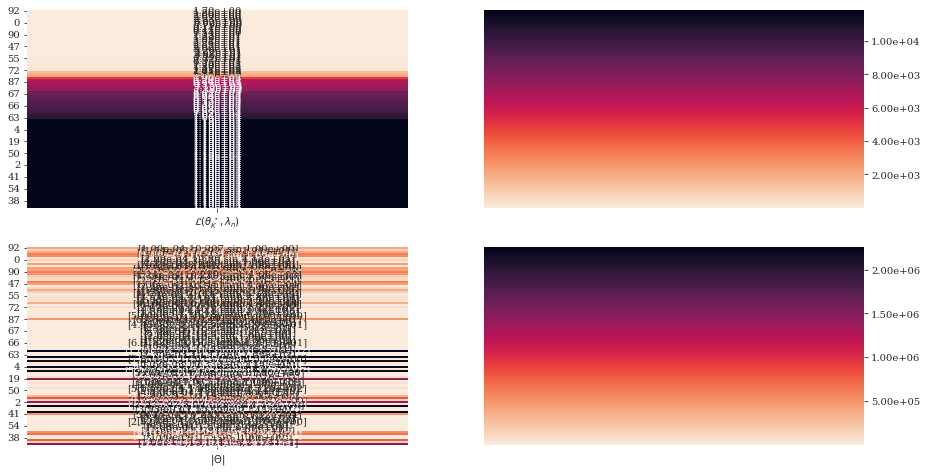

In [11]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15,8))

g =  sns.heatmap(df[['f']], annot =df[['f_format']], fmt = '' , cmap = 'rocket_r', ax = ax1, cbar_kws = dict(use_gridspec=False, orientation = "vertical", format = '%.2e'), cbar = True, xticklabels = [r'$\mathcal{L}(\theta_K^\star, \lambda_n)$'], cbar_ax =ax2)
g =  sns.heatmap(df[['cost']], annot =df[['information']], fmt = '' , cmap = 'rocket_r', ax = ax3, cbar = True, xticklabels = [r'$|\Theta|$'], cbar_kws = dict(use_gridspec=False, orientation = "vertical", format = '%.2e'), cbar_ax=ax4)
#plt.savefig('plots/s35.pdf')